<a href="https://colab.research.google.com/github/Agoston03/Deep-Learning-42/blob/main/deep_learning_42_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a homework project in "Deep Learning a gyakorlatban Python és Lua alapokon".  
The team members are:

* Gyulai Gergő László
* Horváth Ágoston
* Frink Dávid

You can read more information about our chosen homework at the link below:  
https://www.kaggle.com/competitions/isic-2024-challenge

## Download and set

In this section, we will download the necessary libraries and tools.

In [ ]:
!pip install kaggle==1.5.12
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=5e3d3affe66abefee31df672d52f46f10bfdff29d0ba41f9b5f373e39f12748a
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


Configure Kaggle to access the API. You need to copy your own kaggle.json file into Colab in order to validate yourself

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Here, we are downloading the necessary data as a zipped file.

In [ ]:
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [00:18<00:00, 242MB/s]
100% 2.00G/2.00G [00:18<00:00, 115MB/s]



Unpacking the data while skipping the images. This may take a few minutes.

In [ ]:
!unzip isic-2024-challenge.zip -x "train-image/image/*"

Archive:  isic-2024-challenge.zip
  inflating: sample_submission.csv   
  inflating: test-image.hdf5         
  inflating: test-metadata.csv       
  inflating: train-image.hdf5        
  inflating: train-metadata.csv      


Importing the necessary libraries.

In [36]:
import pandas as pd
import numpy as np
from PIL import Image
import io
import h5py
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

These are global variables used throughout the project.

In [ ]:
NUMBER_OF_AUGMENTATIONS = 3
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

## Preparing train, test and valid set

In this section we will create the required datasets for further fitting.


Gather information about the dataset using the metadata. This code loads the metadata into a pandas DataFrame. Quite useful for extracting the IDs.

In [39]:
metadata = pd.read_csv('train-metadata.csv')
metadata.head(2)

<ipython-input-39-dc228b6d879c>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


Check the count of benign and malignant data.

In [ ]:
benign_samples = metadata[metadata['target'] == 0]
malignant_samples = metadata[metadata['target'] == 1]

print(f'Benign images: {len(benign_samples)}')
print(f'Malignant images: {len(malignant_samples)}')

Benign images: 400666
Malignant images: 393


Here are a few sample IDs.

In [38]:
benign_ids = benign_samples['isic_id'].tolist()
malignant_ids = malignant_samples['isic_id'].tolist()

print(f'Benign images ids: {benign_ids[:5]}')
print(f'Malignant images ids: {malignant_ids[:5]}')

Benign images ids: ['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200']
Malignant images ids: ['ISIC_0082829', 'ISIC_0096034', 'ISIC_0104229', 'ISIC_0119495', 'ISIC_0157834']


This function helps visualize the distribution of the generated datasets.

In [67]:
def visualize_dataset_split(train_benign_ids, train_malignant_ids,
                             valid_benign_ids, valid_malignant_ids,
                             test_benign_ids, test_malignant_ids):

  benign_counts = [len(train_benign_ids), len(valid_benign_ids), len(test_benign_ids)]
  malignant_counts = [len(train_malignant_ids), len(valid_malignant_ids), len(test_malignant_ids)]

  labels = ['Train', 'Validation', 'Test']
  width = 0.35

  x = np.arange(len(labels))

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, benign_counts, width, label='Benign', color='#6890F0')
  rects2 = ax.bar(x + width/2, malignant_counts, width, label='Malignant', color='#fdaa48')

  ax.set_ylabel('Number of Samples')
  ax.set_title('Dataset Split Distribution')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.show()

In this section, we will prepare the datasets for the subsequent fitting processes. The training dataset contains a limited number of samples to maintain the desired balance. Unfortunately, there is a smaller fraction of benign samples due to the scarcity of malignant samples.

In [45]:
end = len(malignant_ids)
benign_ids_sampled = benign_ids[:end]

test_split = 0.1
valid_split = 0.1

test_benign_ids = benign_ids_sampled[:int(len(benign_ids_sampled) * test_split)]
test_malignant_ids = malignant_ids[:int(len(malignant_ids) * test_split)]

valid_benign_ids = benign_ids_sampled[int(len(benign_ids_sampled) * test_split):int(len(benign_ids_sampled) * (test_split + valid_split))]
valid_malignant_ids = malignant_ids[int(len(malignant_ids) * test_split):int(len(malignant_ids) * (test_split + valid_split))]

train_benign_ids = benign_ids_sampled[int(len(benign_ids_sampled) * (test_split + valid_split)):]
train_malignant_ids = malignant_ids[int(len(malignant_ids) * (test_split + valid_split)):]

It is a bar chart showing the distribution of the previously created dataset.

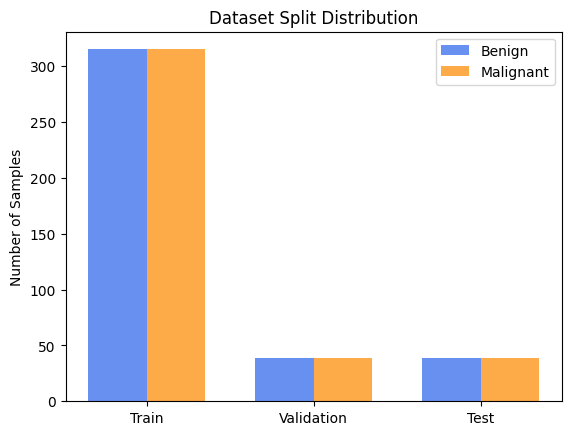

In [68]:
visualize_dataset_split(train_benign_ids,
                        train_malignant_ids,
                        valid_benign_ids,
                        valid_malignant_ids,
                        test_benign_ids,
                        test_malignant_ids)

This code defines another dataset for fitting, which will aid in the augmentation process. Malignant samples will be augmented three times, ensuring that the number of malignant samples matches the number of benign samples. Augmentation is applied to the training dataset, not the validation dataset.

In [49]:
end = len(malignant_ids) * (NUMBER_OF_AUGMENTATIONS + 1)
benign_ids_sampled = benign_ids[:end]

test_split = 0.1
valid_split = 0.1

test_benign_enc_ids = benign_ids_sampled[:int(len(benign_ids_sampled) * test_split)]
test_malignant_enc_ids = malignant_ids[:int(len(malignant_ids) * test_split)]

valid_benign_enc_ids = benign_ids_sampled[int(len(benign_ids_sampled) * test_split):int(len(benign_ids_sampled) * (test_split + valid_split))]
valid_malignant_enc_ids = malignant_ids[int(len(malignant_ids) * test_split):int(len(malignant_ids) * (test_split + valid_split))]

train_benign_enc_ids = benign_ids_sampled[int(len(benign_ids_sampled) * (test_split + valid_split)):]
train_malignant_enc_ids = malignant_ids[int(len(malignant_ids) * (test_split + valid_split)):]


This is a bar chart showing the distribution of the previously created dataset.

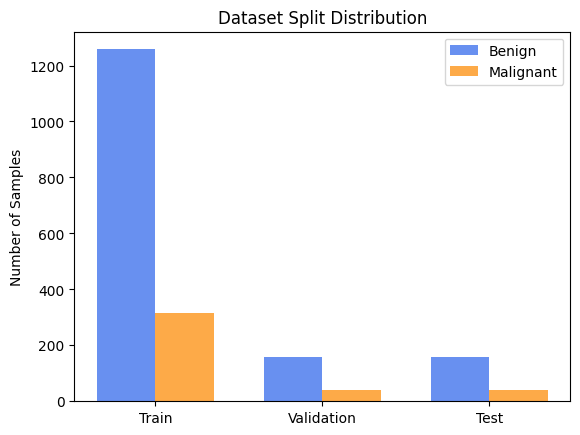

In [69]:
visualize_dataset_split(train_benign_enc_ids,
                        train_malignant_enc_ids,
                        valid_benign_enc_ids,
                        valid_malignant_enc_ids,
                        test_benign_enc_ids,
                        test_malignant_enc_ids)

## Visualizing the images

This section focuses on loading and visualizing a few images.

This function loads a certain number of sample images.


In [ ]:
def load_images_and_labels(h5_file_path, benign_ids, malignant_ids, num_images=5):
    images = []
    labels = []

    image_ids = benign_ids + malignant_ids
    image_ids = image_ids[:num_images]

    with h5py.File(h5_file_path, 'r') as f:
        for img_key in image_ids:
            image_data = f[img_key][()]
            image = np.array(Image.open(io.BytesIO(image_data)).resize((224, 224)))
            images.append(image)
            labels.append(0 if img_key in benign_ids else 1)

    return np.array(images), np.array(labels), image_ids

Visualizing a sample of the data we have.

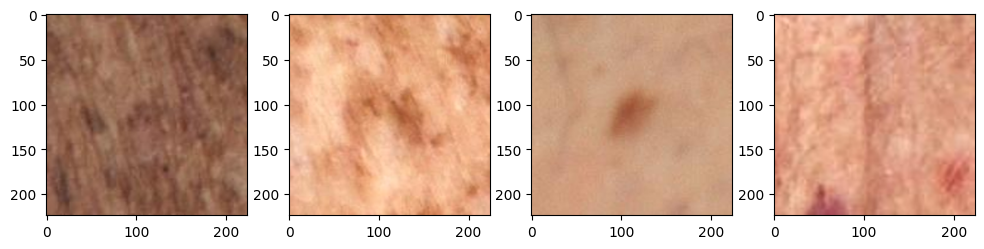

In [ ]:
images, labels, image_ids = load_images_and_labels('train-image.hdf5', train_benign_ids, train_malignant_ids, num_images=4)
nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, image in enumerate(images):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

plt.show()

## Defining and trainging the model

In this section, we define our model for detection. After defining it, we train the model using various approaches.

This function provides a straightforward way to create an instance of an ImageDataGenerator. Simplifying the initialization of this part by defining a function for it.

In [ ]:
def image_generator_factory():
  return ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      rotation_range=30,
      brightness_range=[0.8, 1.2],
  )


It is a helper function for loading images.

In [ ]:
def load_and_preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data))
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(image)

It's a helper function for the various data generator functions. It yields rescaled and augmented images concatenated with their labels.

In [ ]:
def next_data_generator(benign_ids, malignant_ids, augment, image_generator):
  ids = benign_ids + malignant_ids
  id_cycle = itertools.cycle(ids)

  while True:
      with h5py.File('train-image.hdf5', 'r') as f:
          img_id = next(id_cycle)
          image = load_and_preprocess_image(f[img_id][()])
          label = 1 if img_id in malignant_ids else 0
          yield image / 255.0, label

          if label == 1 and augment:
              for _ in range(NUMBER_OF_AUGMENTATIONS):
                  yield image_generator.random_transform(image), label

This function generates images represented as NumPy arrays along with their labels. I added the 'augment' parameter, which allows us to specify whether advanced augmentation is needed in addition to rescaling.

In [ ]:
def data_generator(benign_ids, malignant_ids, image_generator, augment, batch_size=32):
  get_next = next_data_generator(benign_ids, malignant_ids, augment, image_generator)

  while True:
      batch_data, batch_labels = zip(*(
          next(get_next) for _ in range(batch_size)
      ))

      yield np.array(batch_data), np.array(batch_labels)

It's similar to the previous one, but it returns two batches consisting of images instead of labels.

In [ ]:
def autoencoder_data_generator(benign_ids, malignant_ids, image_generator, batch_size=32):
  get_next = next_data_generator(benign_ids, malignant_ids, False, image_generator)

  while True:
      batch_data, _ = zip(*(
          next(get_next) for _ in range(batch_size)
      ))

      yield np.array(batch_data), np.array(batch_data)

We opted for an AutoEncoder, utilizing its encoder to generate enhanced image representations for classification. The input shape is set to (128, 128, 3) by default, representing 128x128 RGB images. The decoder mirrors the operations of the encoder in reverse. For future use, the function also returns the encoder component.

In [ ]:
def build_autoencoder(input_shape=(128, 128, 3)):
  input_img = Input(shape=input_shape)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

  encoder = Model(input_img, encoded)

  autoencoder = Model(input_img, decoded)

  autoencoder.compile(
      optimizer='adam',
      loss='mean_squared_error',
      metrics=['accuracy', 'precision', 'recall']
  )

  return autoencoder, encoder

In this section, the training of the AutoEncoder is completed. The fitting process uses a balanced and smaller dataset, consisting of approximately 600 images, without applying augmentation.

In [ ]:
image_generator = image_generator_factory()

train_generator = autoencoder_data_generator(train_benign_ids, train_malignant_ids, image_generator, BATCH_SIZE)
validation_generator = autoencoder_data_generator(valid_benign_ids, valid_malignant_ids, image_generator, BATCH_SIZE)

steps_per_epoch = len(train_benign_ids + train_malignant_ids) // BATCH_SIZE
validation_steps = len(valid_benign_ids + valid_malignant_ids) // BATCH_SIZE

autoencoder, encoder = build_autoencoder((IMG_WIDTH, IMG_HEIGHT, 3))

autoencoder.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  epochs=10,
  verbose=2
)

Epoch 1/10
19/19 - 13s - 659ms/step - accuracy: 0.9510 - loss: 0.0192 - precision: 0.9975 - recall: 0.7007 - val_accuracy: 0.9931 - val_loss: 0.0192 - val_precision: 0.9977 - val_recall: 0.3348
Epoch 2/10
19/19 - 1s - 59ms/step - accuracy: 0.9994 - loss: 0.0174 - precision: 0.9976 - recall: 0.5430 - val_accuracy: 0.9992 - val_loss: 0.0181 - val_precision: 0.9986 - val_recall: 0.6628
Epoch 3/10
19/19 - 1s - 61ms/step - accuracy: 0.9993 - loss: 0.0157 - precision: 0.9982 - recall: 0.6606 - val_accuracy: 0.9930 - val_loss: 0.0166 - val_precision: 0.9988 - val_recall: 0.6377
Epoch 4/10
19/19 - 1s - 59ms/step - accuracy: 0.9994 - loss: 0.0131 - precision: 0.9983 - recall: 0.5993 - val_accuracy: 0.9937 - val_loss: 0.0104 - val_precision: 1.0000 - val_recall: 0.5768
Epoch 5/10
19/19 - 1s - 61ms/step - accuracy: 0.9994 - loss: 0.0056 - precision: 0.9995 - recall: 0.5857 - val_accuracy: 0.9931 - val_loss: 0.0038 - val_precision: 0.9999 - val_recall: 0.4745
Epoch 6/10
19/19 - 1s - 59ms/step - ac

This demonstrates the utility of the AutoEncoder, as it accurately decodes the images despite a significant amount of noise.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


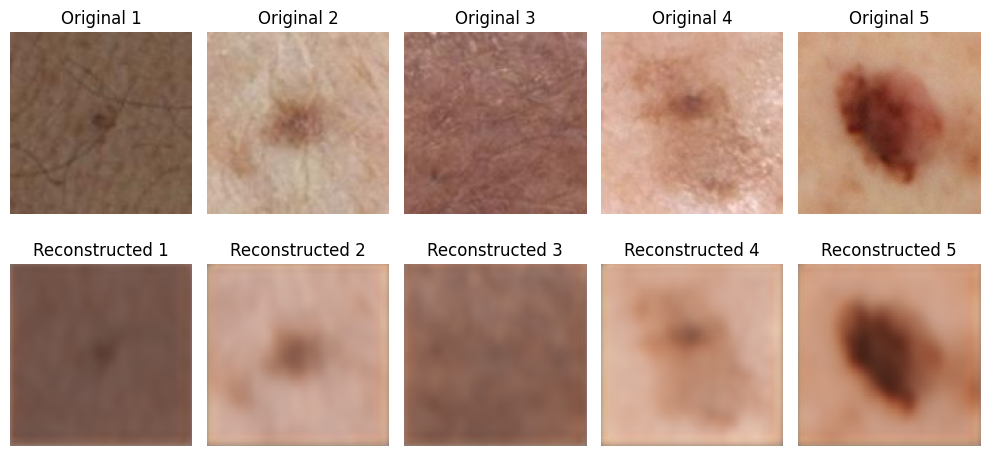

In [ ]:
def reconstruct_images(autoencoder, images):
    reconstructed_images = autoencoder.predict(images)
    return reconstructed_images

num_images_to_visualize = 5
validation_images, _ = next(validation_generator)
validation_images = validation_images[:num_images_to_visualize]

reconstructed_images = reconstruct_images(autoencoder, validation_images)

plt.figure(figsize=(10, 5))
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(validation_images[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, i + 1 + num_images_to_visualize)
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

This code defines a list of callbacks to be used during training.

In [ ]:
callbacks = [
  EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max'),
  ModelCheckpoint(filepath='best_model.keras', monitor='val_precision', save_best_only=True, mode='max')
]

This function define a model based on the previously trained encoder.

In [ ]:
def build_model(base_model):
  x = base_model.output
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=output)

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['recall', 'precision', 'accuracy'])

  return model

Training the model.  
This might also be the subject of different modifications in the future.

In [ ]:
model = build_model(encoder)

train_generator = data_generator(train_benign_enc_ids, train_malignant_enc_ids, image_generator, True, batch_size=BATCH_SIZE)
validation_generator = data_generator(valid_benign_enc_ids, valid_malignant_enc_ids, image_generator, False, batch_size=BATCH_SIZE)

steps_per_epoch = (len(train_benign_enc_ids) + len(train_malignant_enc_ids) * (NUMBER_OF_AUGMENTATIONS + 1)) // BATCH_SIZE
validation_steps = len(valid_benign_ids + valid_malignant_ids) // BATCH_SIZE

history_encoder = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  epochs=50,
  verbose=2,
  callbacks=callbacks
)

Epoch 1/50
78/78 - 15s - 197ms/step - accuracy: 0.9167 - loss: 622.1387 - precision: 0.9895 - recall: 0.8409 - val_accuracy: 0.0000e+00 - val_loss: 27.8532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
78/78 - 12s - 153ms/step - accuracy: 0.6759 - loss: 2.4142 - precision: 0.6585 - recall: 0.7197 - val_accuracy: 0.0000e+00 - val_loss: 7.5979 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
78/78 - 11s - 145ms/step - accuracy: 0.7833 - loss: 198.2561 - precision: 0.7422 - recall: 0.8627 - val_accuracy: 0.5469 - val_loss: 6.0898 - val_precision: 0.5469 - val_recall: 1.0000
Epoch 4/50
78/78 - 10s - 126ms/step - accuracy: 0.6370 - loss: 29.5605 - precision: 0.5883 - recall: 0.8934 - val_accuracy: 0.0625 - val_loss: 15.2539 - val_precision: 0.0625 - val_recall: 1.0000
Epoch 5/50
78/78 - 8s - 102ms/step - accuracy: 0.7368 - loss: 18.6657 - precision: 0.7085 - recall: 0.7973 - val_accuracy: 0.0000e+00 - val_loss: 10.3755 - val_precision: 0.0000e+00 - val_recal

This function creates a confusion matrix for better visualization.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

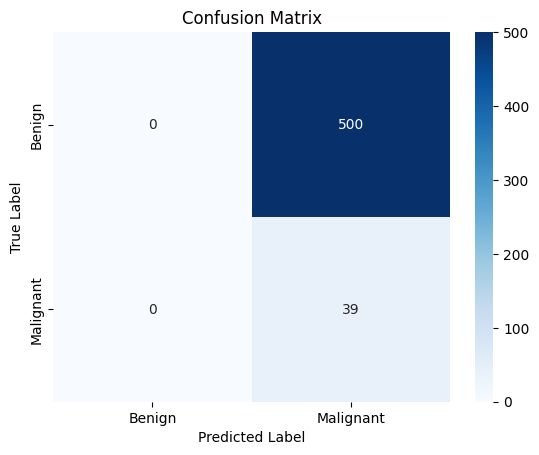

In [35]:
def evaluate_and_visualize(model, test_benign_ids, test_malignant_ids):
    y_true = []
    y_pred = []

    with h5py.File('train-image.hdf5', 'r') as f:
        for img_id in test_benign_ids + test_malignant_ids:
            image = load_and_preprocess_image(f[img_id][()])
            image = image / 255.0
            image = np.expand_dims(image, axis=0)
            label = 1 if img_id in test_malignant_ids else 0
            prediction = model.predict(image)
            y_true.append(label)
            y_pred.append(np.round(prediction).flatten()[0])

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return y_pred, y_true

y_pred, y_true = evaluate_and_visualize(model, benign_ids[2000:2500], test_malignant_ids)

Partial area under the ROC curve (pAUC) above 80% true positive rate (TPR) for binary classification of malignant examples.

The receiver operating characteristic (ROC) curve illustrates the diagnostic ability of a given binary classifier system as its discrimination threshold is varied. However, there are regions in the ROC space where the values of TPR are unacceptable in clinical practice. Systems that aid in diagnosing cancers are required to be highly-sensitive, so this metric focuses on the area under the ROC curve AND above 80% TRP. Hence, scores range from [0.0, 0.2].

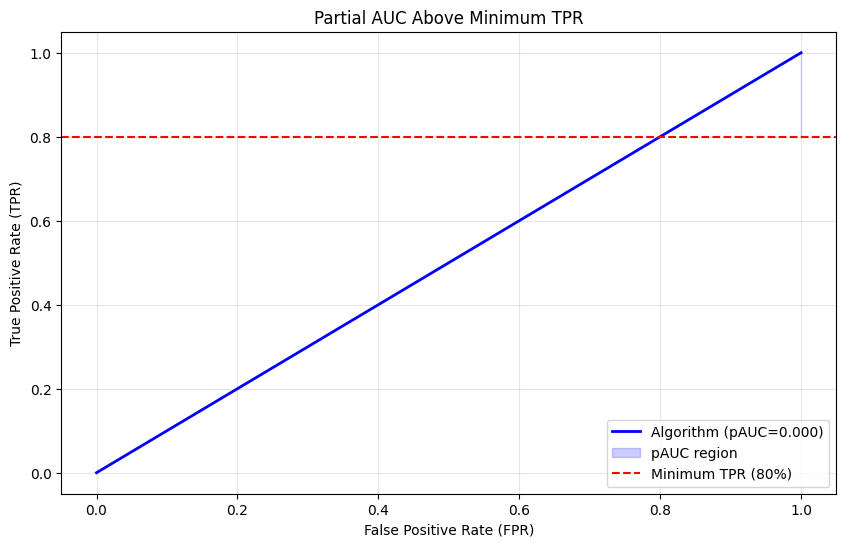

In [ ]:
def generate_pAUC_plot(algorithm_probs, true_labels, min_tpr=0.8):
  fpr_a, tpr_a, _ = roc_curve(true_labels, algorithm_probs)

  min_tpr_idx_a = np.where(tpr_a >= min_tpr)[0]

  fpr_a_high_tpr, tpr_a_high_tpr = fpr_a[min_tpr_idx_a], tpr_a[min_tpr_idx_a]

  if len(fpr_a_high_tpr) < 2:
      print("Warning: Insufficient data points to calculate pAUC. Returning 0.")
      pAUC_a = 0.0
  else:
      pAUC_a = auc(fpr_a_high_tpr, tpr_a_high_tpr)

  plt.figure(figsize=(10, 6))
  plt.plot(fpr_a, tpr_a, label=f'Algorithm (pAUC={pAUC_a:.3f})', color='blue', linewidth=2)

  if len(fpr_a_high_tpr) > 0 :
      plt.fill_between(fpr_a_high_tpr, tpr_a_high_tpr, min_tpr, color='blue', alpha=0.2, label='pAUC region')

  plt.axhline(y=min_tpr, color='red', linestyle='--', label=f'Minimum TPR ({min_tpr*100:.0f}%)')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Partial AUC Above Minimum TPR')
  plt.legend(loc='lower right')
  plt.grid(alpha=0.3)
  plt.show()

generate_pAUC_plot(y_pred, y_true)